# Fitting Cosmography using `pymc`

As you can see below, this notebook uses `pymc` (the beta release of v4) to sample cosmological parameters from measurements of redshift and distance.

See `README.md` for instructions for installing the necessary prerequesites and the `pymc_cosmology` package.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
from pylab import *

import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
import astropy.cosmology as cosmo
import astropy.units as u
import pymc as pm
import scipy.integrate as si
import seaborn as sns
import xarray as xr

from pymc_cosmology.cosmology import Ez
from pymc_cosmology.models import make_redshift_distance_gaussian_model

sns.set_context('notebook')

We need to draw some synthetic data, so here we calculate $p(z)$ for GW events, assuming that their merger rate traces the SFR from [Madau & Dickinson (2014)](https://ui.adsabs.harvard.edu/abs/2014ARA%26A..52..415M/abstract).  That gives 
$$
p\left( z \right) \propto \frac{\left( 1 + z \right)^{2.7}}{1 + \left( \frac{1+z}{1+1.9}\right)^{5.6}} \frac{\mathrm{d} V}{\mathrm{d} z} \frac{1}{1+z}
$$
(the final term comes from the redshifting of the source frame time to the detector frame).

Text(0, 0.5, '$p(z)$')

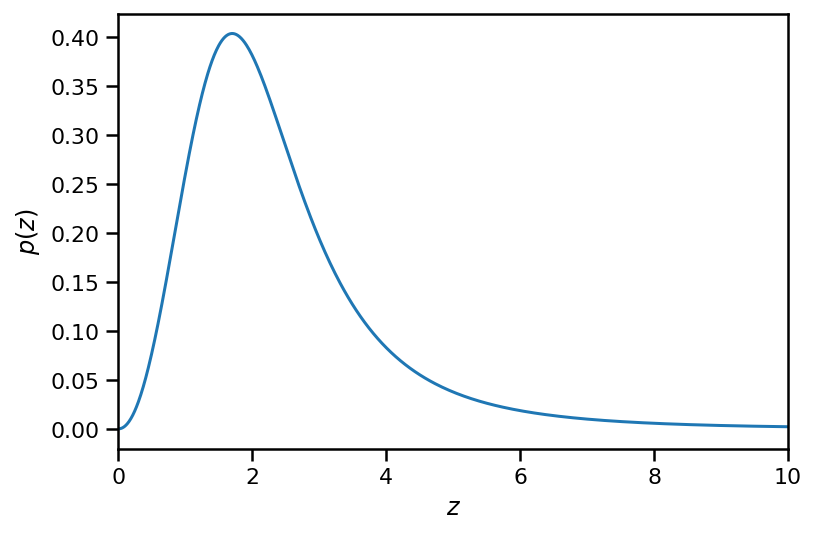

In [3]:
zi = expm1(linspace(log(1), log(1+100), 1024))
pz = (1+zi)**1.7/(1+((1+zi)/(1+1.9))**5.6)*cosmo.Planck18.differential_comoving_volume(zi).to(u.Gpc**3/u.sr)
cz = si.cumulative_trapezoid(pz, zi, initial=0)
plot(zi, pz/cz[-1])
axis(xmin=0, xmax=10)
xlabel(r'$z$')
ylabel(r'$p(z)$')

Now that we have $p(z)$ we draw `Nobs` sources (1000 sources takes a minute or two to analyze on my laptop, so choose accordingly) from the redshift distribution, and compute their luminosity distances.

Text(0.5, 8.95999999999998, '$z$')

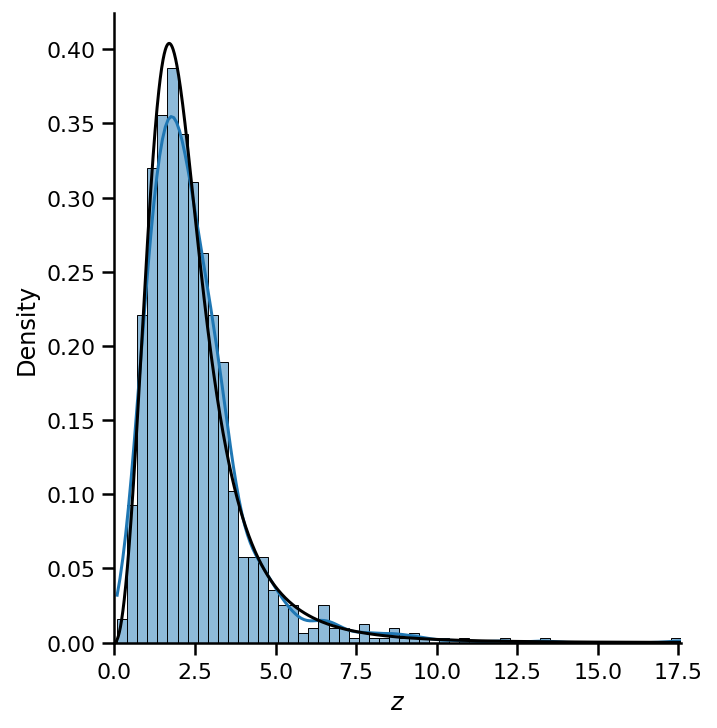

In [4]:
Nobs = 1000
zt = np.interp(np.random.uniform(low=0, high=cz[-1], size=Nobs), cz, zi)
dt = cosmo.Planck18.luminosity_distance(zt).to(u.Gpc).value
sns.displot(zt, kde=True, stat='density')
plot(zi, pz/cz[-1], color='k')
axis(xmin=0, xmax=max(zt))
xlabel(r'$z$')

Then we make mock observations of these sources.  We assume that the only uncertainty in the redshift comes from the width of the NS mass function, which we take to be approximately $\sigma_m / m \simeq 0.1$; we assume that the detector-frame mass is measured so well that it has effectively zero uncertainty.  Thus 
$$
\log m_\mathrm{det} = \log m + \log\left( 1 + z \right),
$$
and 
$$
\frac{\sigma_z}{1+z} \simeq \frac{\sigma_m}{m} \simeq 0.1.
$$

We assume that the *fractional* uncertainty on the amplitude of the signal, and therefore $\sigma_d / d$ scales inversely with SNR, reaching 30\% at $z \simeq 10$; thus 
$$
\frac{\sigma_d}{d} \simeq 0.3 \frac{d}{d\left( z = 10 \right)}.
$$
We place a lower limit on $\sigma_d / d \sim 0.1$ even at low distances to avoid the un-physical situation where we have $\sigma_d \to 0$.

In [5]:
d10 = cosmo.Planck18.luminosity_distance(10).to(u.Gpc).value
sigma_z = 0.1*(1 + zt)
sigma_d = 0.3*dt*(1/3 + dt/d10)
zo = zt + sigma_z*randn(Nobs)
do = dt + sigma_d*randn(Nobs)

Let's plot our measurements and truth:

Text(0, 0.5, '$d_L / \\mathrm{Gpc}$')

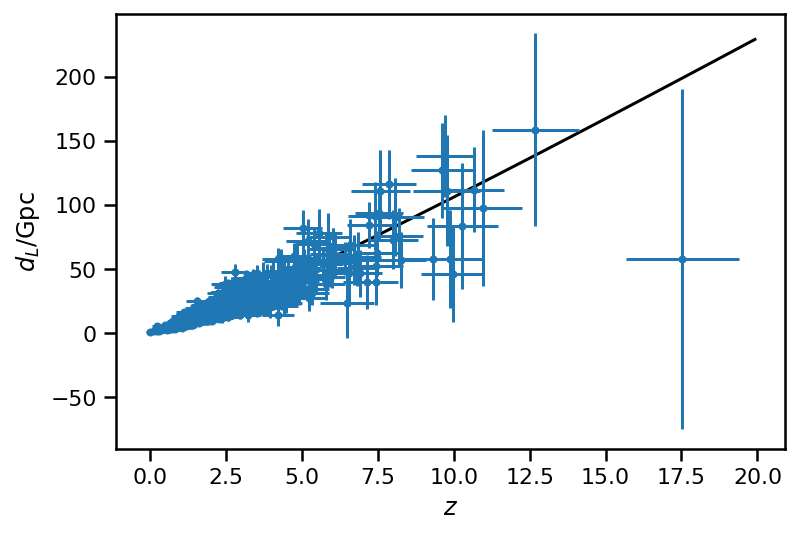

In [6]:
m = zi < 20
plot(zi[m], cosmo.Planck18.luminosity_distance(zi).to(u.Gpc).value[m], color='k')
errorbar(zo, do, xerr=sigma_z, yerr=sigma_d, fmt='.')
xlabel(r'$z$')
ylabel(r'$d_L / \mathrm{Gpc}$')

Now we construct the model, and fit it:

In [15]:
with make_redshift_distance_gaussian_model(zo, sigma_z, do, sigma_d) as model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/wfarr/miniconda3/envs/pymc_cosmology/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, hz0.5, Om, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Let's just look at a summary of the cosmological variables.

In [16]:
with model:
    display(az.summary(trace, var_names=['h', 'Om', 'w']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.690,0.053,0.599,0.788,0.002,0.002,541.0,819.0,1.0
Om,0.327,0.052,0.235,0.423,0.002,0.002,545.0,868.0,1.0
w,-1.032,0.257,-1.495,-0.616,0.009,0.007,750.0,1074.0,1.0


A traceplot is a good way to double-check that the sampling has converged:

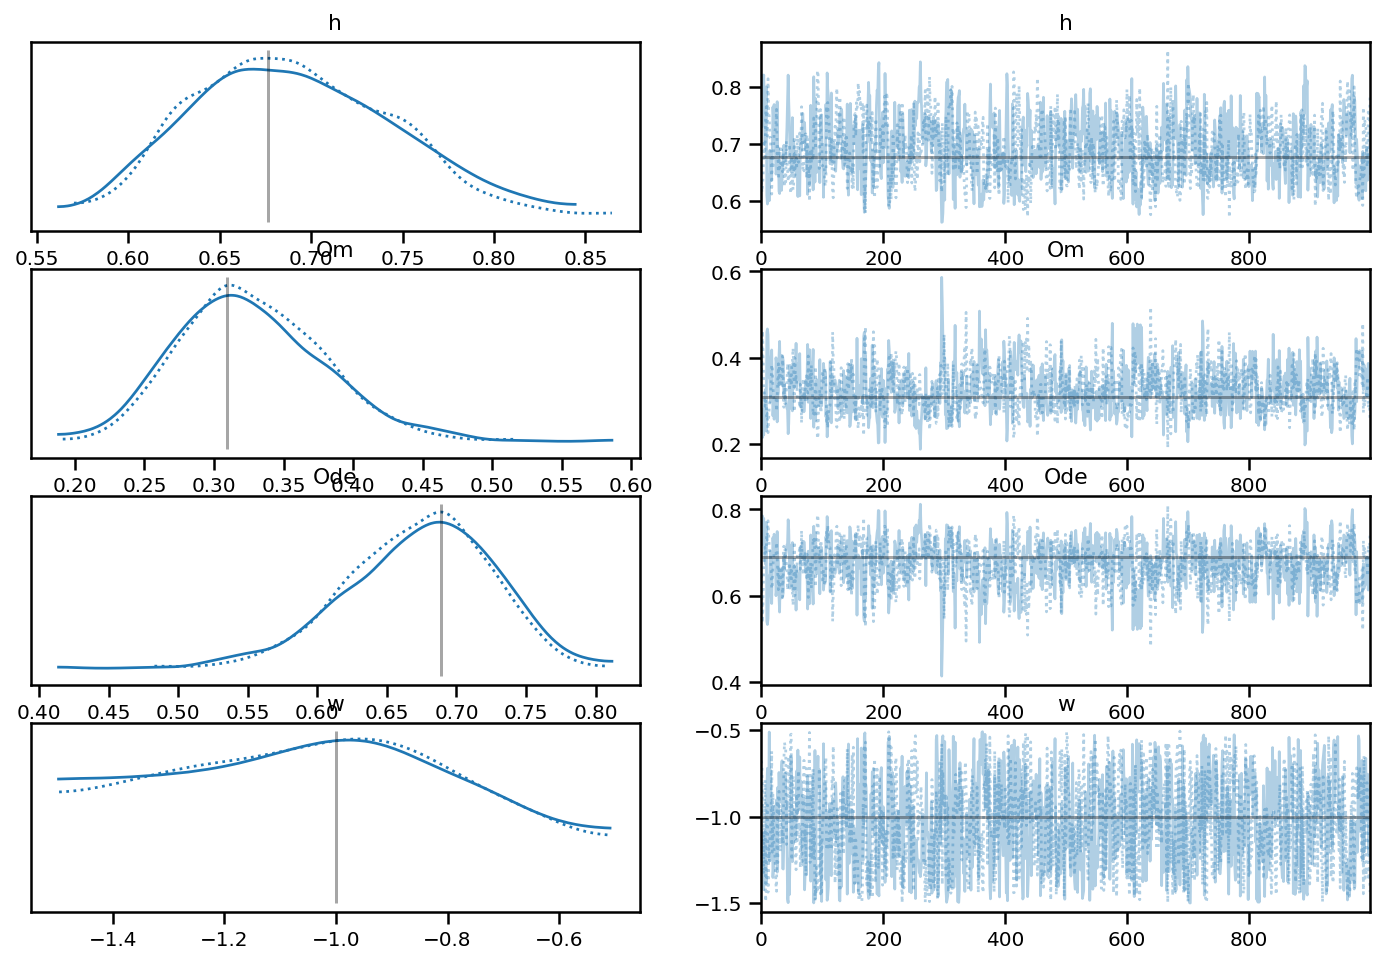

In [17]:
with model:
    az.plot_trace(trace, compact=True, var_names=['h', 'Om', 'Ode', 'w'],
                  lines=[('h', {}, cosmo.Planck18.H0/100),
                         ('Om', {}, cosmo.Planck18.Om0),
                         ('Ode', {}, cosmo.Planck18.Ode0),
                         ('w', {}, -1)])

Here we make a corner plot of the "natural" cosmological variables and the variables in which we sample (so the lower right 3x3 is the distribution that the sampler sees).  You can see that using $h\left(z = 0.5\right)$ helps a lot to de-correlate the cosmological parameters, which makes sampling easier.

array([[<AxesSubplot:ylabel='h'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Om'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='w'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='hz0.5'>,
        <AxesSubplot:xlabel='Om'>, <AxesSubplot:xlabel='w'>,
        <AxesSubplot:xlabel='hz0.5'>]], dtype=object)

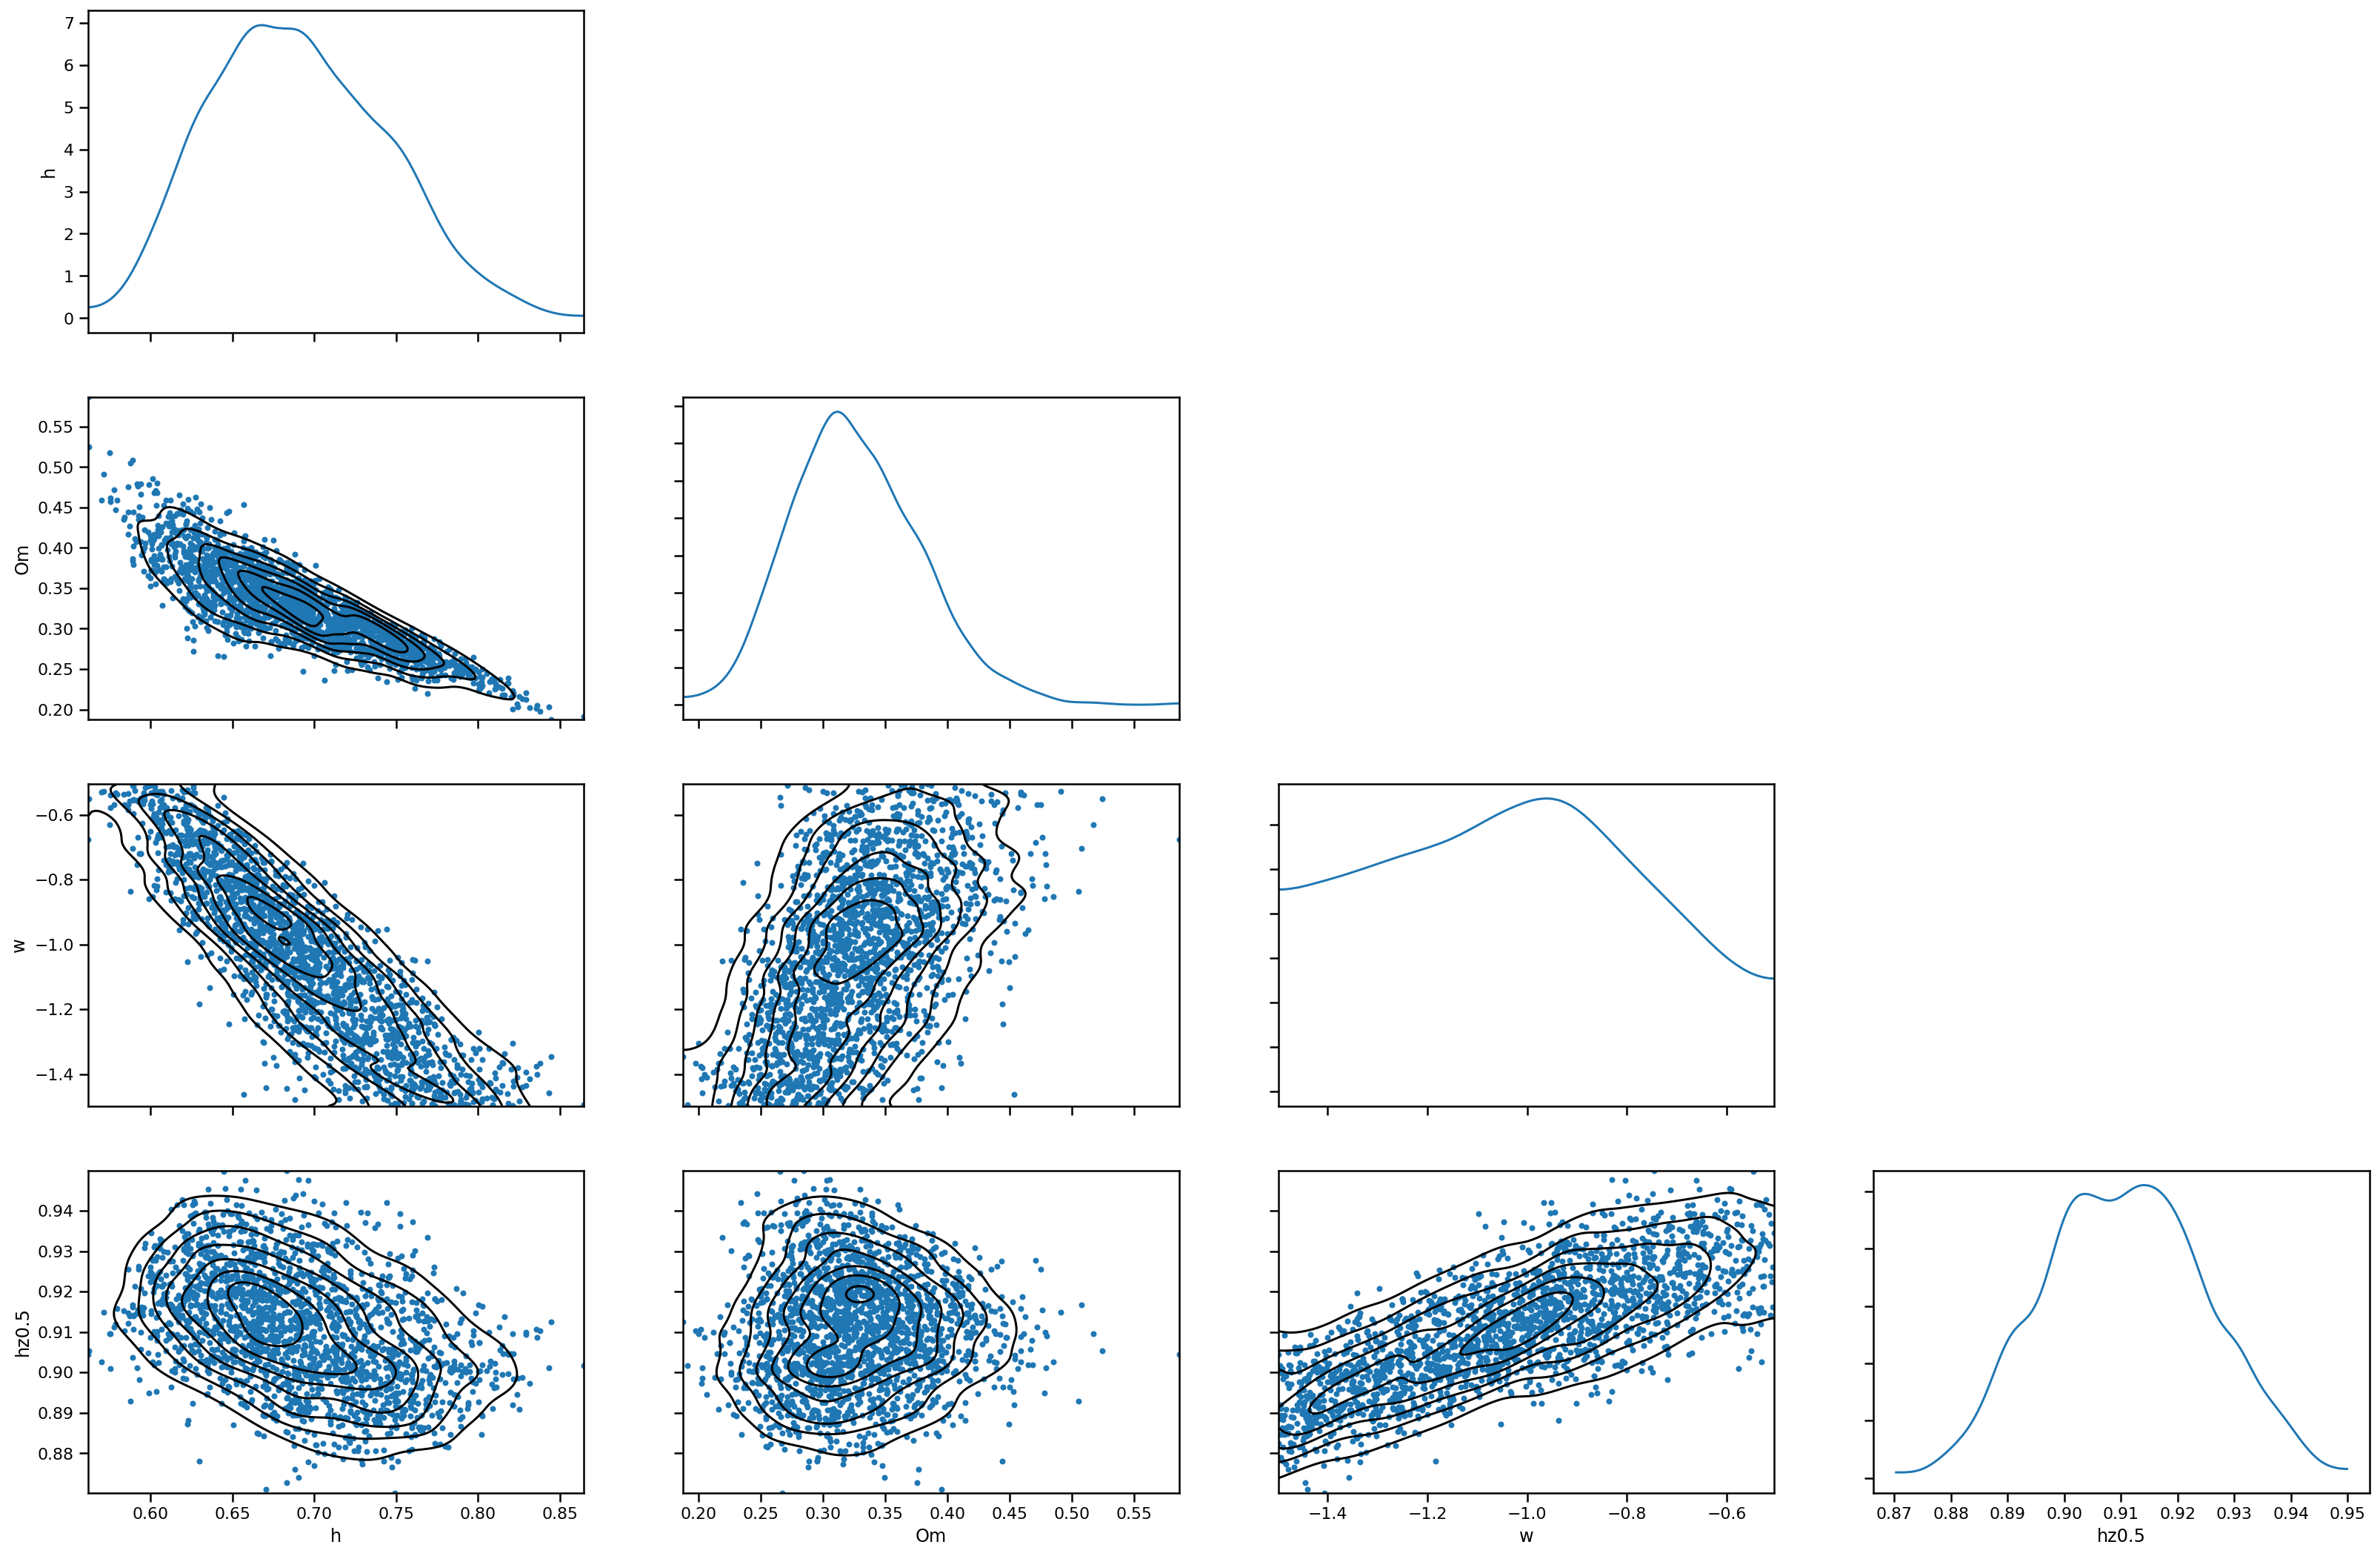

In [18]:
az.plot_pair(trace, var_names=['h', 'Om', 'w', 'hz0.5'], marginals=True, kind=['scatter', 'kde'], divergences=True)

If you just want the cosmological parameters:

array([[<AxesSubplot:ylabel='h'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Om'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>,
        <AxesSubplot:xlabel='w'>]], dtype=object)

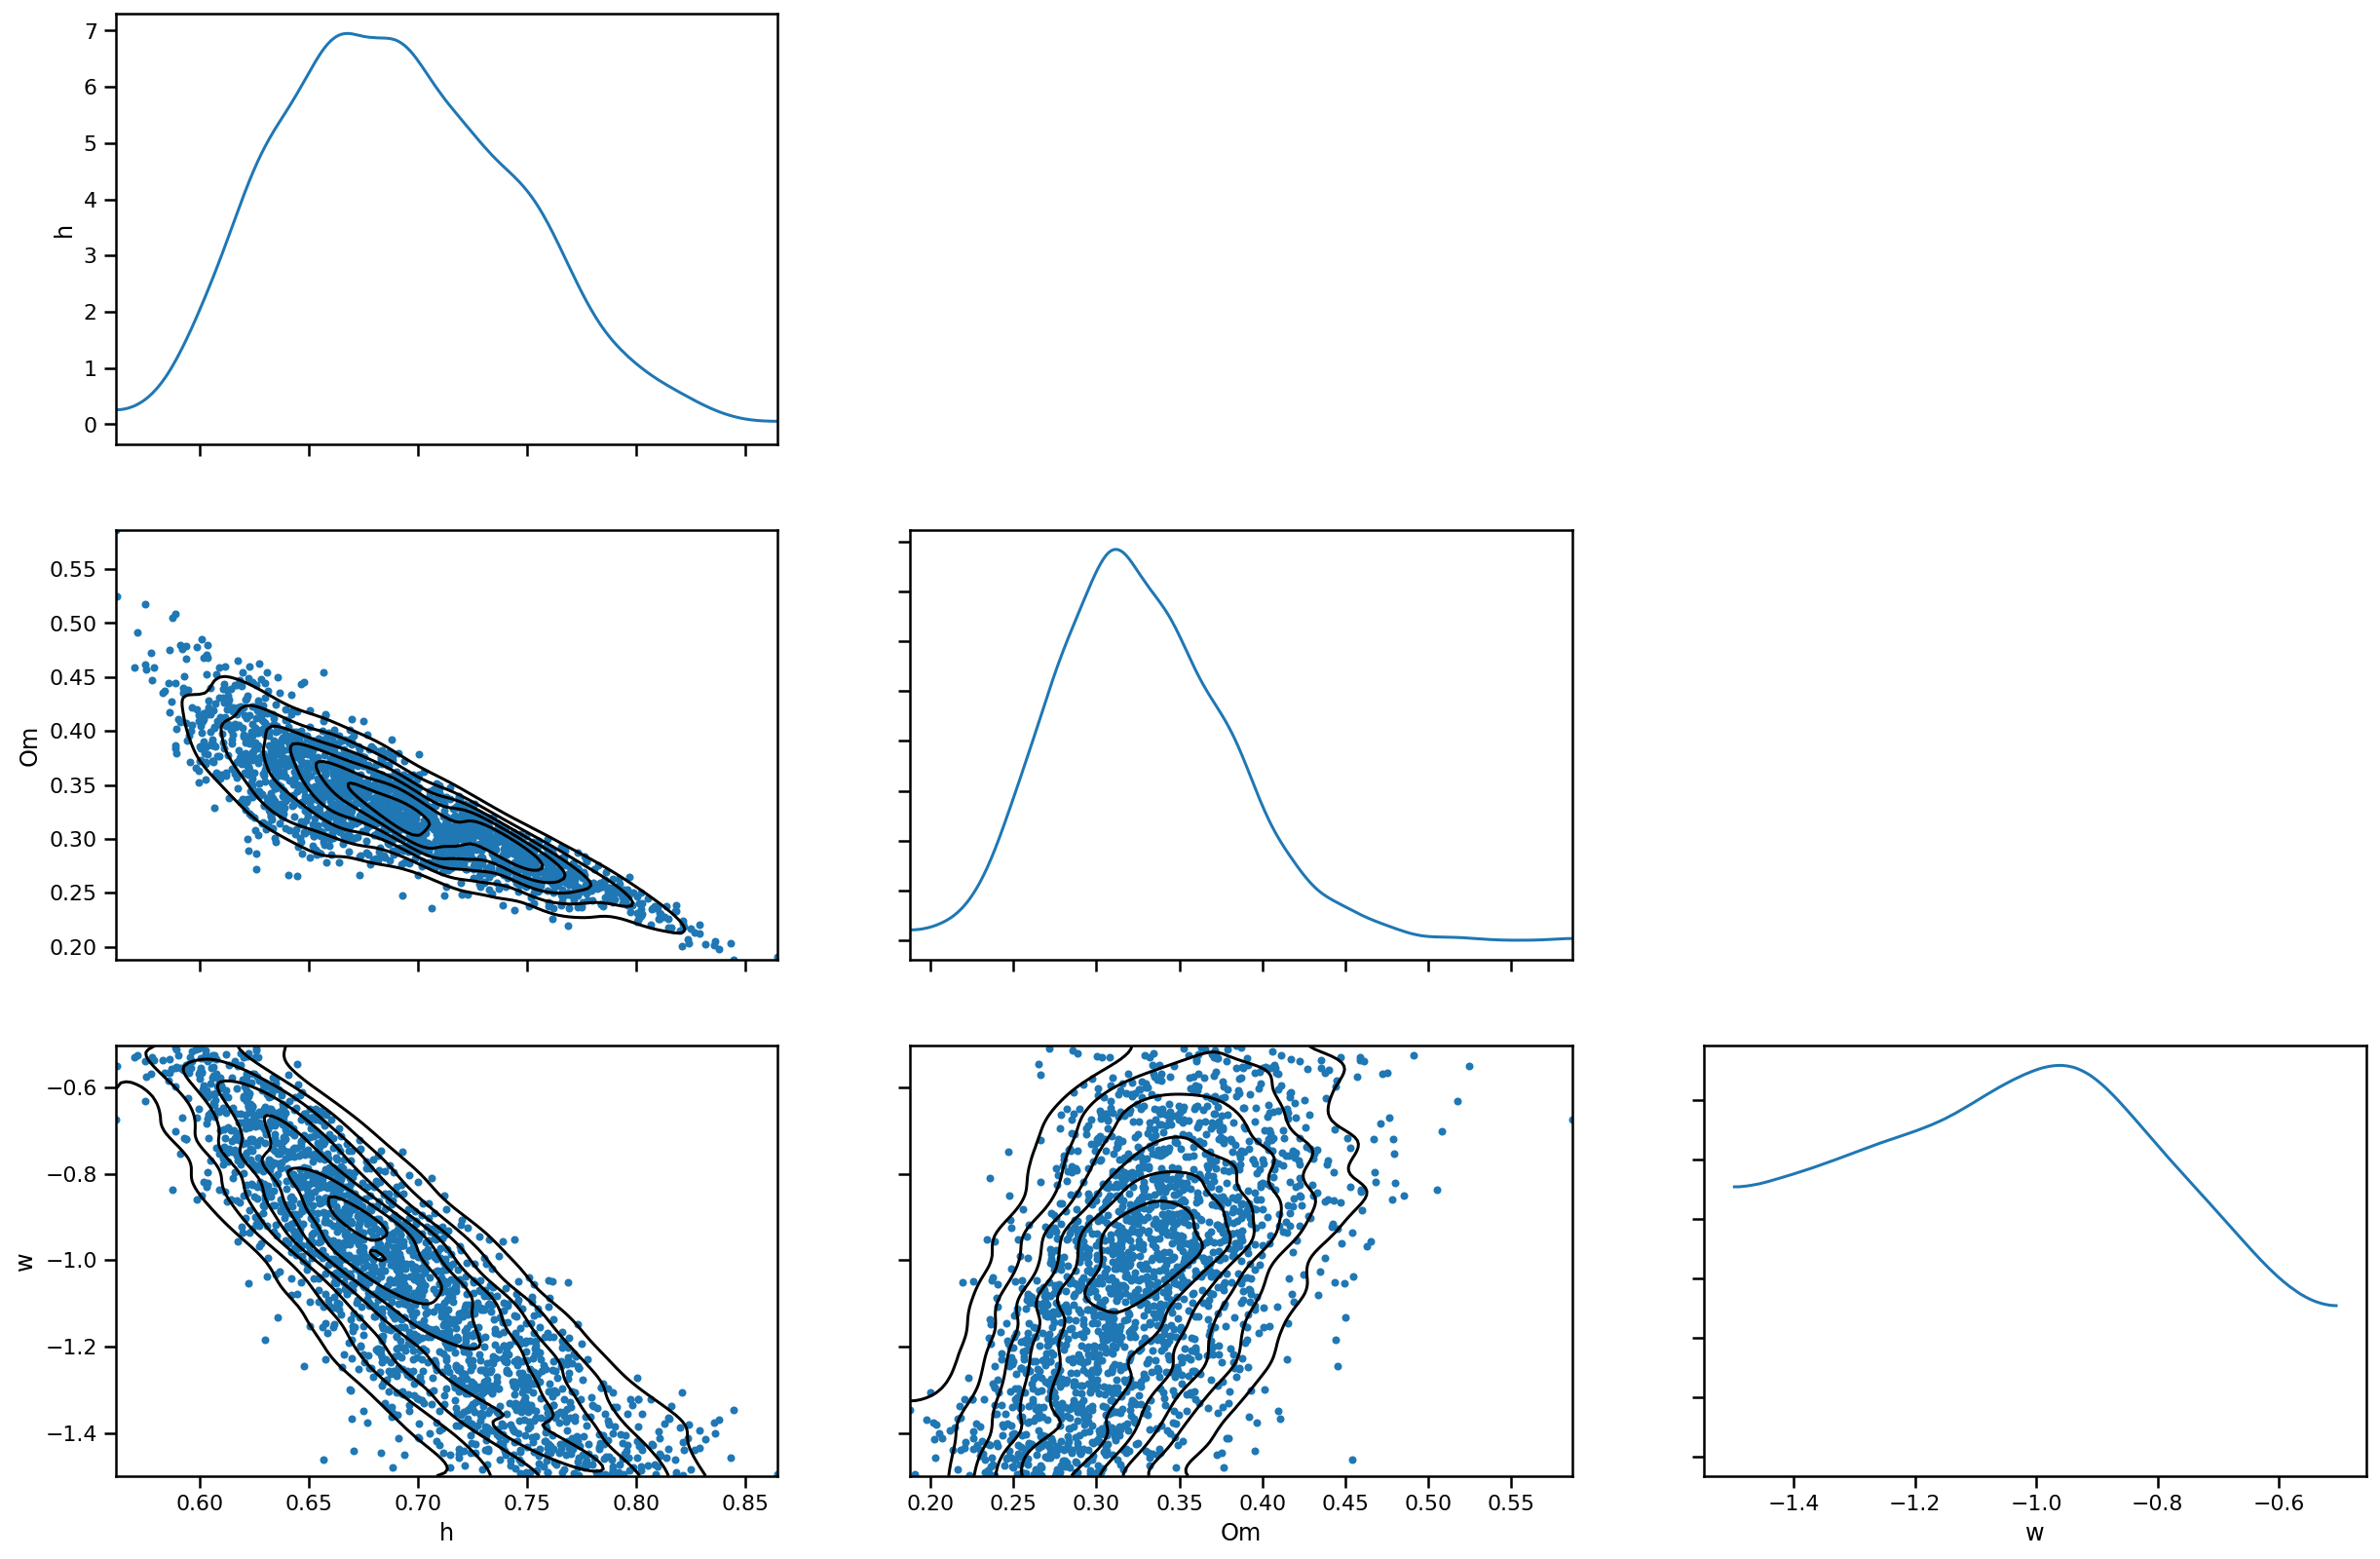

In [19]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'], divergences=True)

We would like to make plots of $h(z) = h E\left( z \mid \Omega_M, w \right)$.  We can add this quantity to the stored chain using the following snippet; we add a new coordinate to the posterior dataset representing the interpolated values of $z$, and then produce $h(z)$ which has shape `(zinterp, chain, draw)` due to the `broadcast` call merging the coordinates of `h`, `Om` and `w` (`(chain, draw)`) with the coordinates of `zinterp` (`(zinterp,)`).

In [20]:
trace.posterior = trace.posterior.assign_coords(zinterp=zi)
post = trace.posterior
z = post.coords['zinterp']
h = post.h
Om = post.Om
w = post.w

h,Om,w,z = xr.broadcast(h, Om, w, z)
hz = h*Ez(array(z), array(Om), array(w)).eval()
post['hz'] = hz

We can make a plot of the posterior median, 1-, and 2-sigma intervals of $h(z)$; the "neck" at $z = 0.5$ is readily identified.

Text(0, 0.5, '$h(z)$')

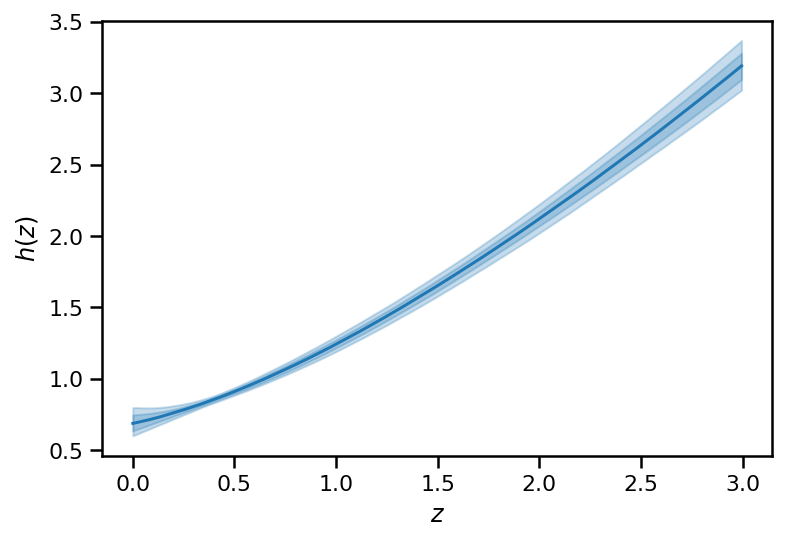

In [21]:
p = post.sel(zinterp=slice(0,3))
l, = plot(p.coords['zinterp'], p.hz.median(dim=['chain', 'draw']))
fill_between(p.coords['zinterp'], p.hz.quantile(0.84, dim=['chain', 'draw']), p.hz.quantile(0.16, dim=['chain', 'draw']), alpha=0.25, color=l.get_color())
fill_between(p.coords['zinterp'], p.hz.quantile(0.975, dim=['chain', 'draw']), p.hz.quantile(0.025, dim=['chain', 'draw']), alpha=0.25, color=l.get_color())
xlabel(r'$z$')
ylabel(r'$h(z)$')

Here is the standard deviation of $\log(h(z))$ versus $z$ (roughly the relative error in $z$), showing even more clearly the "neck" at $z = 0.5$.

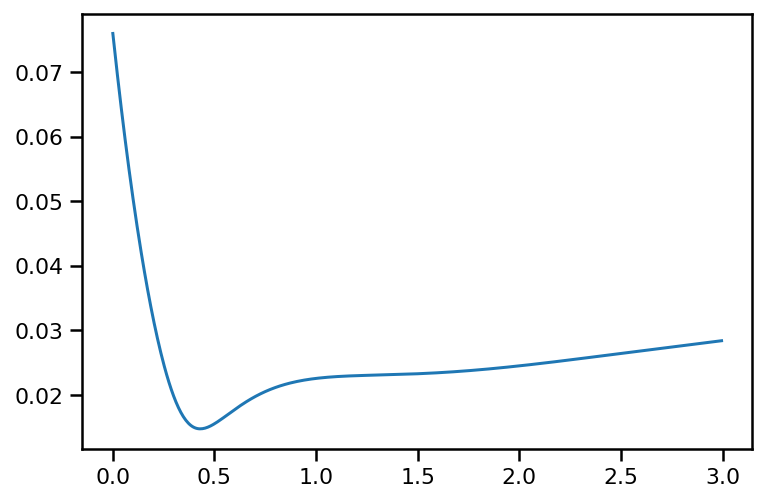

In [22]:
shz = log(p.hz).std(dim=['chain', 'draw'])
plot(p.coords['zinterp'], shz)

Let's look at the posterior inference on the distances and redshifts of our sources.  Because we enforce that all our sources follow the $z$-$d_L$ relation defined by the cosmology, they "snap" to the curve with much smaller uncertainty (since the cosmology allows to combine the precision of both measurements of $d_L$ and $z$).

Text(0, 0.5, '$d_L / \\mathrm{Gpc}$')

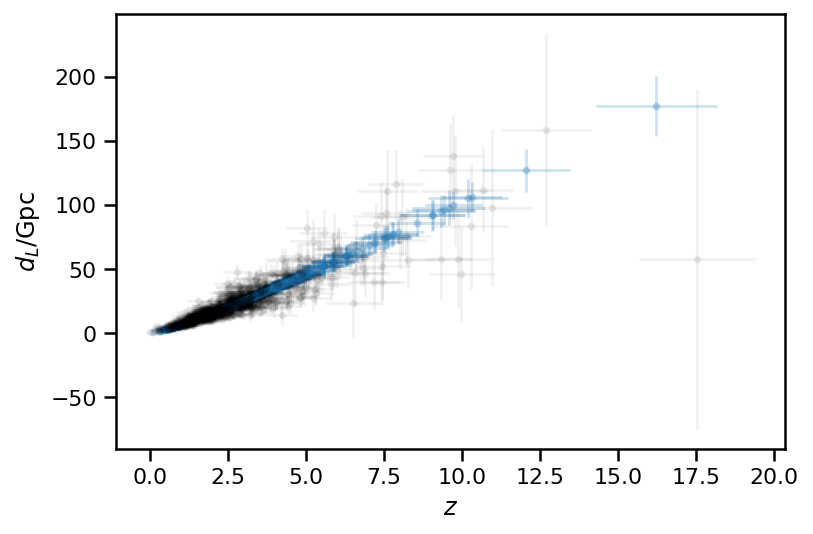

In [23]:
z = post.z
d = post.dL
dim = ['chain', 'draw']
errorbar(z.mean(dim=dim), d.mean(dim=dim), xerr=z.std(dim=dim), yerr=d.std(dim=dim), fmt='.', alpha=0.2, label='Posterior')
errorbar(zo, do, xerr=sigma_z, yerr=sigma_d, fmt='.', color='k', alpha=0.05, label='Observations')
xlabel(r'$z$')
ylabel(r'$d_L / \mathrm{Gpc}$')

Or, looking in $\log 1 + z$ and $\log d_L$:

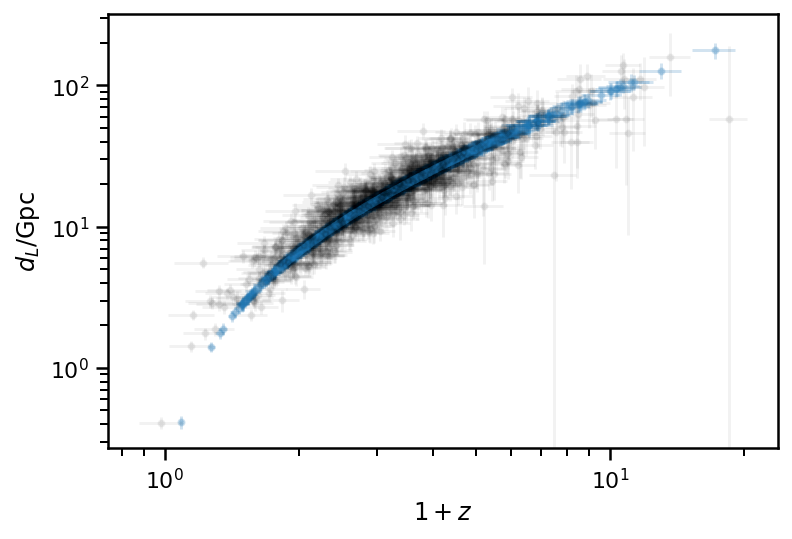

In [24]:
z = post.z
d = post.dL
dim = ['chain', 'draw']
errorbar(1+z.mean(dim=dim), d.mean(dim=dim), xerr=z.std(dim=dim), yerr=d.std(dim=dim), fmt='.', alpha=0.2, label='Posterior')
errorbar(1 + zo, do, xerr=sigma_z, yerr=sigma_d, fmt='.', color='k', alpha=0.05, label='Observations')
xlabel(r'$1 + z$')
ylabel(r'$d_L / \mathrm{Gpc}$')
xscale('log')
yscale('log')

One interesting thing to look at is the residuals: how close do the observations come to the fitted values, and is this consistent with the observational uncertainties?  This is a bit complicated here in 2D (the estimated value can be discrepant from the observations in both $d_L$ and $z$).  Below we plot for each observation
$$
\frac{1}{2} \chi^2 \equiv \frac{1}{2} \left[\left( \frac{\left\langle z \right\rangle - z_\mathrm{obs}}{\sigma_z}\right)^2 + \left( \frac{\left\langle d_L \right\rangle - d_{L,\mathrm{obs}}}{\sigma_d}\right)^2 \right]
$$
where the expectations are taken over the posterior for each variable.  Roughly speaking, $\left\langle \chi^2 \right\rangle \simeq 2$, so these quantities should scatter around 1:

Text(0, 0.5, '$\\chi^2$')

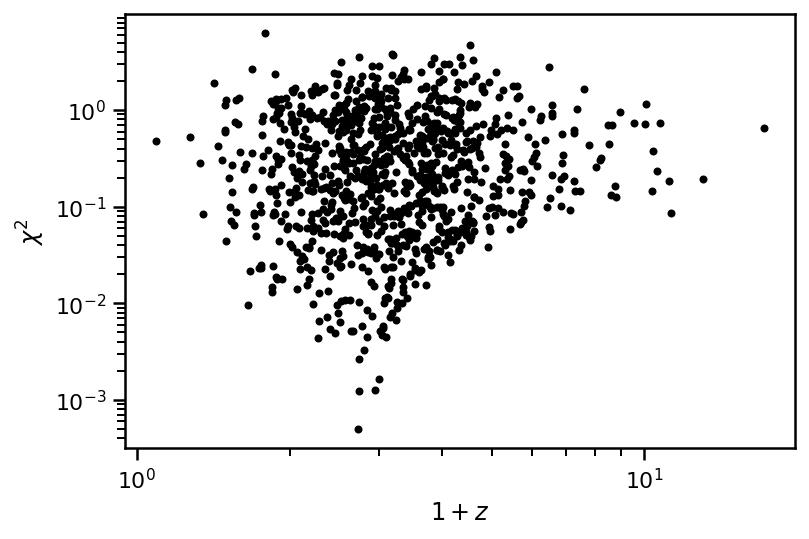

In [25]:
plot(1 + z.mean(dim=dim), 0.5*(np.square((z.mean(dim=dim).values-zo)/sigma_z) + np.square((d.mean(dim=dim).values-do)/sigma_d)), '.k')
xscale('log')
yscale('log')
xlabel(r'$1 + z$')
ylabel(r'$\chi^2$')

I don't know why the $\chi^2$ values get so low for a few observations around $z \simeq 2.75$, but maybe this is where the combination of lots of observations and errorbars becomes fortuitious.

Combining the last two plots:

Text(0.5, 0, '$1 + z$')

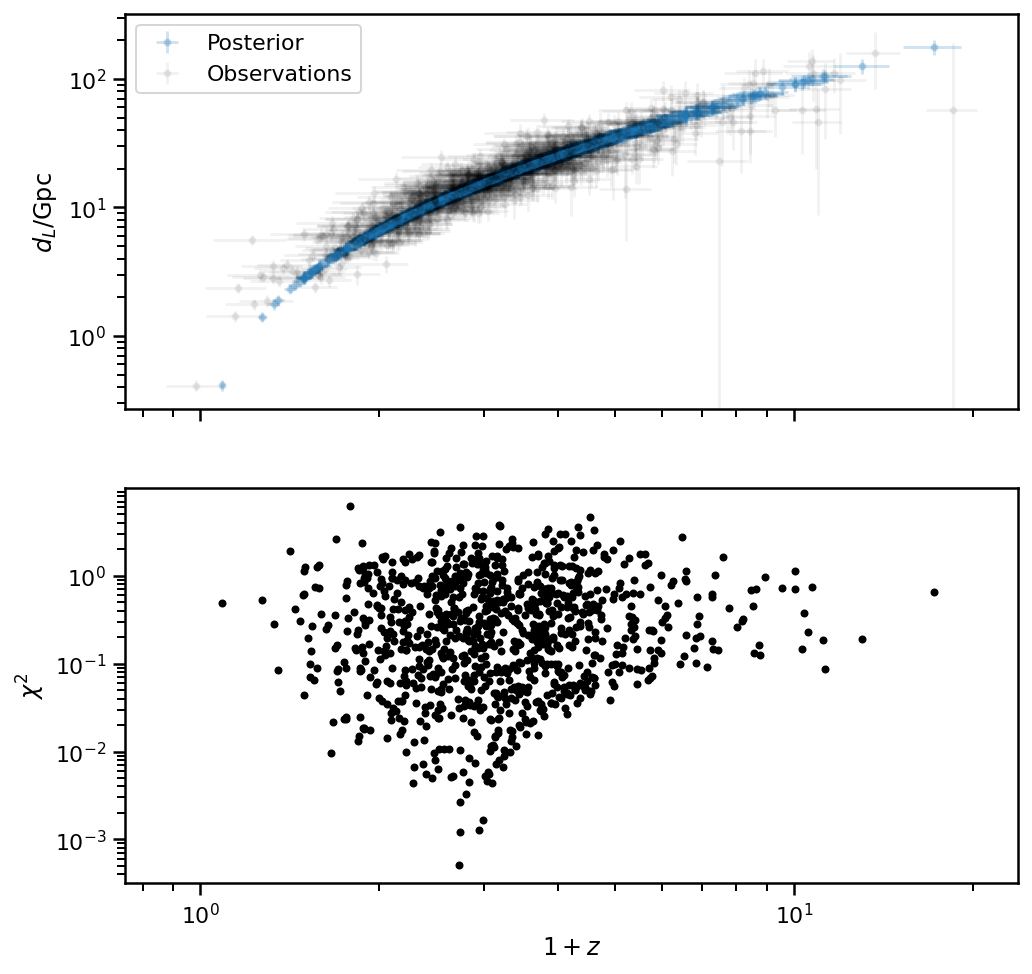

In [26]:
z = post.z
d = post.dL
dim = ['chain', 'draw']

fig, axes = subplots(2, 1, figsize=(8, 8), sharex=True)

axes[0].errorbar(1+z.mean(dim=dim), d.mean(dim=dim), xerr=z.std(dim=dim), yerr=d.std(dim=dim), fmt='.', alpha=0.2, label='Posterior')
axes[0].errorbar(1 + zo, do, xerr=sigma_z, yerr=sigma_d, fmt='.', color='k', alpha=0.05, label='Observations')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylabel(r'$d_L / \mathrm{Gpc}$')

axes[1].plot(1 + z.mean(dim=dim), 0.5*(np.square((z.mean(dim=dim).values-zo)/sigma_z) + np.square((d.mean(dim=dim).values-do)/sigma_d)), '.k')
axes[1].set_yscale('log')
axes[1].set_ylabel(r'$\chi^2$')
axes[1].set_xlabel(r'$1 + z$')